In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import sklearn
import os
pd.options.plotting.backend = "plotly"

### Reading Data

In [3]:
df = pd.read_csv('data/pokemon.csv', index_col='pokedex_number')
df.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,name,percentage_male,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
pokedex_number,,,,,,,,,,,,,,,,,,,,,
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,Bulbasaur,88.1,65,65,45,grass,poison,6.9,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,Ivysaur,88.1,80,80,60,grass,poison,13.0,1,0
3,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,Venusaur,88.1,122,120,80,grass,poison,100.0,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,Charmander,88.1,60,50,65,fire,NaN,8.5,1,0
5,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,Charmeleon,88.1,80,65,80,fire,NaN,19.0,1,0


In [4]:
df.shape

(801, 40)

# Exploratoy Data Analysis (EDA)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801 entries, 1 to 801
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

In [6]:
df.describe()

,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,...,experience_growth,height_m,hp,percentage_male,sp_attack,sp_defense,speed,weight_kg,generation,is_legendary
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,...,8.010000e+02,781.000000,801.000000,703.000000,801.000000,801.000000,801.000000,781.000000,801.000000,801.000000
mean,0.996255,1.057116,0.968789,1.073970,1.068976,1.065543,1.135456,1.192884,0.985019,1.034020,...,1.054996e+06,1.163892,68.958801,55.155761,71.305868,70.911361,66.334582,61.378105,3.690387,0.087391
std,0.597248,0.438142,0.353058,0.654962,0.522167,0.717251,0.691853,0.604488,0.558256,0.788896,...,1.602558e+05,1.080326,26.576015,20.261623,32.353826,27.942501,28.907662,109.354766,1.930420,0.282583
min,0.250000,0.250000,0.000000,0.000000,0.250000,0.000000,0.250000,0.250000,0.000000,0.250000,...,6.000000e+05,0.100000,1.000000,0.000000,10.000000,20.000000,5.000000,0.100000,1.000000,0.000000
25%,0.500000,1.000000,1.000000,0.500000,1.000000,0.500000,0.500000,1.000000,1.000000,0.500000,...,1.000000e+06,0.600000,50.000000,50.000000,45.000000,50.000000,45.000000,9.000000,2.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+06,1.000000,65.000000,50.000000,65.000000,66.000000,65.000000,27.300000,4.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,1.059860e+06,1.500000,80.000000,50.000000,91.000000,90.000000,85.000000,64.800000,5.000000,0.000000
max,4.000000,4.000000,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,1.640000e+06,14.500000,255.000000,100.000000,194.000000,230.000000,180.000000,999.900000,7.000000,1.000000


In [7]:
df.columns

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'sp_attack', 'sp_defense',
       'speed', 'type1', 'type2', 'weight_kg', 'generation', 'is_legendary'],
      dtype='object')

In [8]:
num_cols = list(df.select_dtypes(exclude=['object']).columns)
obj_cols = list(df.select_dtypes(include=['object']).columns)
null_cols = df.columns[df.isnull().any()]

print("Number of numeric columns:", len(num_cols))
print("Number of object columns:", len(obj_cols))
print("Number of null columns:", len(null_cols))

Number of numeric columns: 33
Number of object columns: 7
Number of null columns: 4


## Null Columns

In [9]:
df[null_cols].head()

,height_m,percentage_male,type2,weight_kg
pokedex_number,,,,
1,0.7,88.1,poison,6.9
2,1.0,88.1,poison,13.0
3,2.0,88.1,poison,100.0
4,0.6,88.1,NaN,8.5
5,1.1,88.1,NaN,19.0


In [10]:
df[null_cols].isnull().sum()

height_m            20
percentage_male     98
type2              384
weight_kg           20
dtype: int64

In [11]:
df.type2.fillna("None", inplace=True)

The other columns we will check correlations to impute the best values for NaN.

## Object Columns

In [12]:
df[obj_cols].head()

,abilities,capture_rate,classfication,japanese_name,name,type1,type2
pokedex_number,,,,,,,
1,"['Overgrow', 'Chlorophyll']",45,Seed Pokémon,Fushigidaneフシギダネ,Bulbasaur,grass,poison
2,"['Overgrow', 'Chlorophyll']",45,Seed Pokémon,Fushigisouフシギソウ,Ivysaur,grass,poison
3,"['Overgrow', 'Chlorophyll']",45,Seed Pokémon,Fushigibanaフシギバナ,Venusaur,grass,poison
4,"['Blaze', 'Solar Power']",45,Lizard Pokémon,Hitokageヒトカゲ,Charmander,fire,None
5,"['Blaze', 'Solar Power']",45,Flame Pokémon,Lizardoリザード,Charmeleon,fire,None


In [13]:
df.capture_rate = df.capture_rate.replace('30 (Meteorite)255 (Core)', 30)
df.capture_rate = df.capture_rate.astype(int)

### Type

In [14]:
dict_color_types = {"Water": "rgb(51, 153, 255)",
                    "Normal": "#e0e0d1",
                    "Grass": "#47d147",
                    "Bug": "#669900",
                    "Psychic": "#ff33cc",
                    "Fire": "#ff0000",
                    "Rock": "#ffd24d",
                    "Electric": "#ffff00",
                    "Poison": "#990099",
                    "Ground": "#cc9900",
                    "Dark": "#1a001a",
                    "Fighting": "#ff4000",
                    'Ghost': "#1a001a",
                    'Dragon': "#0033cc",
                    'Steel': "#999966",
                    'Ice': "#00ffff",
                    'Fairy': "#ffccee",
                    'Flying': "#d1e0e0",
                    }   

In [15]:
from plotly.subplots import make_subplots

count_type1 = df.groupby('type1').size().sort_values(ascending=True)
count_type1.index = count_type1.index.map(lambda x: x.capitalize())
count_type2 = df.groupby('type2').size().sort_values(ascending=True)
count_type2.index = count_type2.index.map(lambda x: x.capitalize())

fig = make_subplots(rows=1, cols=2, subplot_titles=("Type 1", "Type 2"),
                    )

for idx, typ in enumerate([count_type1, count_type2]):
    fig.add_trace(go.Bar(y=typ.index, x=typ.values, 
                       text=typ.values, textposition='outside',
                       orientation='h',
                       marker_color=typ.index.map(dict_color_types),
                       name="Type "+str(idx+1),
                       ),
                       row=1, col=idx+1)
    if idx == 1: # update range to show text on bars
        fig.update_xaxes(visible=False, range=[0, 500], row=1, col=idx+1) 
    else:
        fig.update_xaxes(visible=False, range=[0, 130], row=1, col=idx+1)

fig.update_layout(title='Nº of Pokemon Types',
                 template='plotly_white', width=1000, height=600,
                 showlegend=False,
                 margin=dict(l=40, r=10, t=100, b=20),
                 yaxis_title="Type",
                 )

fig.show()

In [16]:
print("Pokémons that have flying as their primary type:")
df[df.type1 == 'flying'][["name", "type1", "type2"]]

Pokémons that have flying as their primary type:


,name,type1,type2
pokedex_number,,,
641,Tornadus,flying,None
714,Noibat,flying,dragon
715,Noivern,flying,dragon


### Classification

In [17]:
fig = df["classfication"].value_counts().hist()
fig.update_layout(title="Classification Distribution",
                    template='plotly_white', width=1000, height=400,
                    showlegend=False,
)

We have too many exclusive classifications, so we will ignore this column. 

In [18]:
obj_cols.remove('classfication')

### Abilities

In [19]:
def first_ability(l):
    if l[0] != '[':
        return l
    else:
        l = l.replace("'", "").replace(" ", "").strip('[]').split(',')
        l.sort()
        return l[0]

In [20]:
def len_abilities(l):
    if l[0] != '[':
        return 1
    else:
        l = l.replace("'", "").replace(" ", "").strip('[]').split(',')
        return len(l)

In [21]:
df["n_abilities"] = df.abilities.map(len_abilities)

In [22]:
df.n_abilities.value_counts().plot(kind='bar')
fig.update_layout(title="Nº of Abilities for Pokémon",
                    template='plotly_white', width=1000, height=400,
                    showlegend=False,
)

In [23]:
obj_cols.remove('name')
obj_cols.remove('abilities')
obj_cols.remove('japanese_name')
obj_cols.remove('capture_rate')
obj_cols

['type1', 'type2']

## Numerical Columns

In [24]:
num_cols = list(df.select_dtypes(exclude=['object']).columns)
num_cols.sort()
len(num_cols)

35

In [25]:
num_cols_against = num_cols[:18].copy()
num_cols_against

['against_bug',
 'against_dark',
 'against_dragon',
 'against_electric',
 'against_fairy',
 'against_fight',
 'against_fire',
 'against_flying',
 'against_ghost',
 'against_grass',
 'against_ground',
 'against_ice',
 'against_normal',
 'against_poison',
 'against_psychic',
 'against_rock',
 'against_steel',
 'against_water']

In [26]:
corr = df[num_cols_against].corr()
px.imshow(corr, color_continuous_scale=px.colors.sequential.Plasma)

In [27]:
def mean_against(x, y):
    return (x+y)/2

In [28]:
df["against_dark_ghost"] = mean_against(df["against_ghost"], df["against_dark"])
num_cols.append("against_dark_ghost")

In [29]:
num_cols.remove("against_dark")
num_cols.remove("against_ghost")

In [30]:
num_cols[18:]

['base_happiness',
 'base_total',
 'capture_rate',
 'defense',
 'experience_growth',
 'generation',
 'height_m',
 'hp',
 'is_legendary',
 'n_abilities',
 'percentage_male',
 'sp_attack',
 'sp_defense',
 'speed',
 'weight_kg',
 'against_dark_ghost']

In [31]:
att_cols = ['attack', 'defense', 'hp', 'sp_attack', 'sp_defense', 'speed', 'base_total']

In [32]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=7, cols=1, subplot_titles=("Attack", "Defense", "HP", "Sp. Atk", "Sp. Def", "Speed", "Total"))

for i, col in enumerate(att_cols):
    fig.add_trace(go.Histogram(x=df[col], name=col), row=i+1, col=1)
    
fig.update_layout(width=800, height=800, template='plotly_white', showlegend=False)
fig.update_yaxes(range=[0, 100])
fig.show()

In [33]:
print("The strongest Pokémon! (including their mega-evolution)")
df[["base_total", "name"]].sort_values("base_total", ascending=False).head(14)

The strongest Pokémon! (including their mega-evolution)


,base_total,name
pokedex_number,,
150,780,Mewtwo
384,780,Rayquaza
383,770,Groudon
382,770,Kyogre
493,720,Arceus
718,708,Zygarde
381,700,Latios
373,700,Salamence
248,700,Tyranitar


In [34]:
set(num_cols[18:]) - set(att_cols)

{'against_dark_ghost',
 'base_happiness',
 'capture_rate',
 'experience_growth',
 'generation',
 'height_m',
 'is_legendary',
 'n_abilities',
 'percentage_male',
 'weight_kg'}

In [35]:
fig = df.generation.value_counts().plot(kind='bar')
fig.update_layout(title="Nº of Pokémon per Generation",
                    template='plotly_white', width=1000, height=400,
                    showlegend=False,
                    yaxis_title="Nº of Pokémon",
                    xaxis_title="Generation",
)

In [36]:
fig = px.scatter(df, x="weight_kg", y="height_m", facet_col="is_legendary", color="is_legendary",
                 hover_data=dict(is_legendary=False,
                                 ), hover_name="name",)
fig.update_layout(title="Weight vs Height",
                    template='plotly_white', width=1000, height=400,
                    showlegend=False,
                    yaxis_title="Height (m)",
                    
                    
)
fig.update_xaxes(title_text="Weight (kg)")
fig.update_coloraxes(showscale=False)
fig.show()

In [37]:
df[["weight_kg", "height_m"]].describe()

,weight_kg,height_m
count,781.000000,781.000000
mean,61.378105,1.163892
std,109.354766,1.080326
min,0.100000,0.100000
25%,9.000000,0.600000
50%,27.300000,1.000000
75%,64.800000,1.500000
max,999.900000,14.500000


We will replace NaN values for their median in both columns.

In [38]:
print("Pokémon that don't have a genre:")
df[df.percentage_male.isnull()].name

Pokémon that don't have a genre:


pokedex_number
81      Magnemite
82       Magneton
100       Voltorb
101     Electrode
120        Staryu
          ...    
797    Celesteela
798       Kartana
799      Guzzlord
800      Necrozma
801      Magearna
Name: name, Length: 98, dtype: object

We will replace their NaN `percentage_male` values with 50.0

In [39]:
df["percentage_male"] = df.percentage_male.fillna(50.0)

In [40]:
df_is_legendary = df[df.is_legendary == 1]
print("Legendary pokémon that has a genre:")
df_is_legendary[~df_is_legendary.percentage_male.isnull()][["name", "percentage_male"]]

Legendary pokémon that has a genre:


,name,percentage_male
pokedex_number,,
144,Articuno,50.0
145,Zapdos,50.0
146,Moltres,50.0
150,Mewtwo,50.0
151,Mew,50.0
...,...,...
797,Celesteela,50.0
798,Kartana,50.0
799,Guzzlord,50.0


Question: how can Heatran be a legendary (and unique) pokémon but have a 50/50 genre distributions?? Is there more than one Heatran 🤔🤔

In [41]:
fig = px.box(df, x="is_legendary", y="base_egg_steps")
fig.update_layout(title="Egg Steps Distribution by Legendary Class",
                  template="plotly_white",
                  xaxis_title="Is Legendary?",
                  yaxis_title="Egg Steps")
fig.show()

In [61]:
fig = px.scatter(df, x="base_egg_steps", y="weight_kg", color="is_legendary", hover_data=dict(is_legendary=False,
                                                                                              ), hover_name="name",)
fig.update_layout(title="Egg Steps vs Weight",
                    template="plotly_white",
                    xaxis_title="Egg Steps",
                    yaxis_title="Weight (kg)",
                    showlegend=False)
fig.show()

Heatran is the Legendary Pokémon with least Egg Steps -> he shouldn't be legendary!

In [43]:
print("Only two non-legendary Pokémon that have Egg Steps > 11k: (non-legendary)")
df[(df.base_egg_steps > 11000) & (df.is_legendary==0)][["name", "base_egg_steps"]]

Only two non-legendary Pokémon that have Egg Steps > 11k: (non-legendary)


,name,base_egg_steps
pokedex_number,,
772,Type: Null,30720
773,Silvally,30720


Type: Null evolves to Silvally, and we can only capture him one time in the Pokémon Sword and Shield.

'base_happiness',
 'capture_rate',
 'experience_growth',

In [44]:
df[["base_happiness", "capture_rate", "experience_growth"]].describe()

,base_happiness,capture_rate,experience_growth
count,801.000000,801.000000,8.010000e+02
mean,65.362047,98.675406,1.054996e+06
std,19.598948,76.248866,1.602558e+05
min,0.000000,3.000000,6.000000e+05
25%,70.000000,45.000000,1.000000e+06
50%,70.000000,60.000000,1.000000e+06
75%,70.000000,170.000000,1.059860e+06
max,140.000000,255.000000,1.640000e+06


In [45]:
fig = px.scatter(df, "experience_growth", "base_total", color="is_legendary",
                    hover_data=dict(is_legendary=False,
                                                    ), hover_name="name",)
fig.update_layout(title="Experience Growth vs Total",
                    template='plotly_white', width=1000, height=400,
                    showlegend=True,
                    yaxis_title="Base Total",
                    xaxis_title="Experience Growth",
                    
                    
)
fig.show()

In [46]:
fig = px.scatter(df, "capture_rate", "base_total", color="is_legendary",
                    hover_data=dict(is_legendary=False,
                                                    ), hover_name="name",)
fig.update_layout(title="Capture Rate vs Total",
                    template='plotly_white', width=1000, height=400,
                    showlegend=False,
                    yaxis_title="Base Total",
                    xaxis_title="Capture Rate",
                    
                    
)
fig.show()

We can see a negative relationship between `Capture Rate`and `Base Total`

In [47]:
num_cols.remove("is_legendary")
cols = num_cols + obj_cols
X = df[cols]

In [48]:
corr = X.corr()
px.imshow(corr, color_continuous_scale=px.colors.sequential.Plasma)

# Training our Clustering Algorithm

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


cat_pipe = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

prep_pipe = ColumnTransformer([
    ('cat', cat_pipe, obj_cols),
    ('num', num_pipe, num_cols),
])

X_prep = prep_pipe.fit_transform(X)

# What are the real Legendary Pokémons?

In [50]:
from sklearn.mixture import BayesianGaussianMixture

gm = BayesianGaussianMixture(n_components=15, n_init=10, random_state=42)
gm.fit(X_prep)

BayesianGaussianMixture(n_components=15, n_init=10, random_state=42)

In [51]:
np.round(gm.weights_, 2)

array([0.05, 0.1 , 0.04, 0.05, 0.09, 0.06, 0.05, 0.04, 0.05, 0.09, 0.03,
       0.05, 0.26, 0.04, 0.  ])

In [52]:
gm.converged_

True

In [53]:
name = "Lucario"
row = df[df.name == name]
row_prep = prep_pipe.transform(row)

In [54]:
gm.predict(row_prep)

array([8], dtype=int64)

In [55]:
gm.predict_proba(row_prep)

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

How many legendary pokémon there are?

In [56]:
df.is_legendary.value_counts(normalize=True)

0    0.912609
1    0.087391
Name: is_legendary, dtype: float64

In [57]:
densities = gm.score_samples(X_prep)
density_threshold = np.percentile(densities, 9)
anomalies = np.where(densities < density_threshold)

In [58]:
real_legendary = df.iloc[anomalies].name

In [59]:
def get_poke_image(name, df=df):
    image_path = "data/pokemon_images/{}.png".format(name.lower().replace(" ", "-"))
    return image_path

# The Real Legendary Pokémon

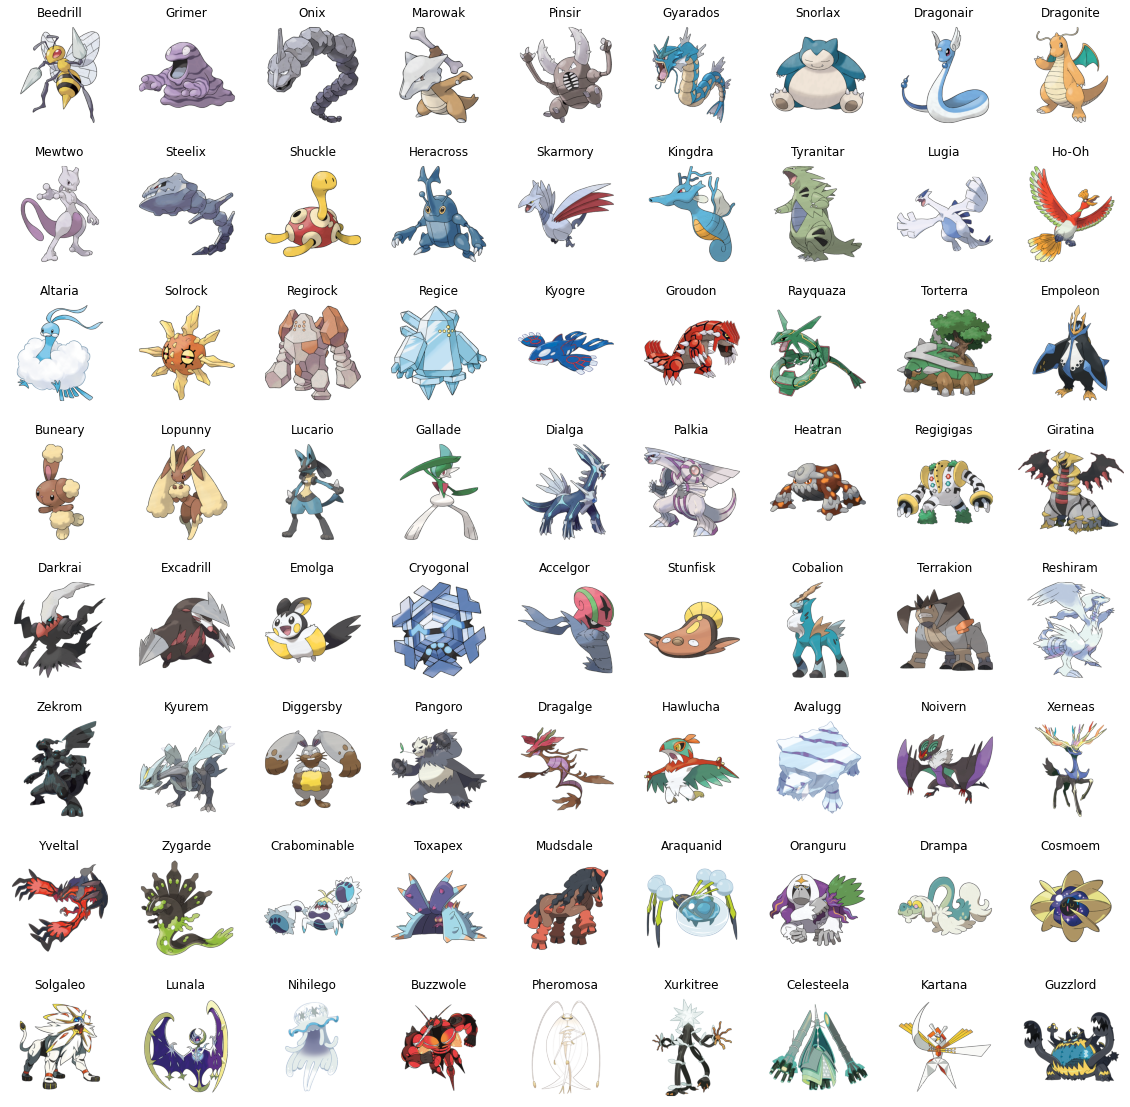

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(8, 9, figsize=(20, 20))

for idx, poke in enumerate(real_legendary):
    image_path = get_poke_image(poke)
    image = plt.imread(image_path)
    ax[idx//9, idx%9].imshow(image)
    ax[idx//9, idx%9].axis("off")
    ax[idx//9, idx%9].set_title(poke)

# Notes

- Who really should be legendary?